In [37]:
import os
from pathlib import Path
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date, timedelta
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [2]:
### American option pricers (Binomial Tree) ###
def binomial_american_call_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t:
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), stock[N, :] - K)

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(stock[n, j] - K, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

def binomial_american_put_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t :
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), K - stock[N, :])

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(K - stock[n, j], (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

print(binomial_american_call_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=1.3759, N=10))
print(binomial_american_put_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10))


10.824553031824337
3.07621086348687


In [3]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_call(S, K, t, t_q, r, q, N, call_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _call_market_price = S, K, t, t_q, r, q, N, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - binomial_american_call_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan
    
def iv_binomial_american_put(S, K, t, t_q, r, q, N, put_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _put_market_price = S, K, t, t_q, r, q, N, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - binomial_american_put_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_call_pricer(S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_put_pricer(S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_call(S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_put(S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0596161269664648
1.0449373998760096
Make sure that 0.25000000000344036 is close to 0.25
Make sure that 0.2500000000007256 is close to 0.25


In [34]:
### Market data fetch ###

ticker = "spy"
option_series = datetime(2021, 9, 17)
chain = options.get_options_chain(ticker, option_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = si.get_live_price("spy")

In [40]:
### Calculate time to expiration ###
expiration_date = option_series + timedelta(hours=16)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

2021-10-15 16:00:00


In [6]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY211015C00190000   2021-08-25 5:33PM EDT   190.0      219.60  261.78   
1    SPY211015C00195000   2021-08-25 5:33PM EDT   195.0      185.09  256.76   
2    SPY211015C00200000   2021-08-25 5:33PM EDT   200.0      227.46  251.84   
3    SPY211015C00210000   2021-08-25 5:33PM EDT   210.0      205.07  241.79   
4    SPY211015C00215000   2021-08-25 5:33PM EDT   215.0      171.93  236.80   
5    SPY211015C00220000   2021-08-25 5:33PM EDT   220.0      194.96  231.79   
6    SPY211015C00225000   2021-08-25 5:33PM EDT   225.0      201.79  226.80   
7    SPY211015C00230000   2021-08-25 5:33PM EDT   230.0      210.75  221.80   
8    SPY211015C00235000   2021-08-25 5:33PM EDT   235.0      203.40  216.80   
9    SPY211015C00240000   2021-08-25 5:33PM EDT   240.0      198.40  211.80   
10   SPY211015C00245000   2021-08-25 5:33PM EDT   245.0      196.10  206.79   
11   SPY211015C00250000   2021-08-25 5:33PM EDT   25

In [7]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     245.0    207.300     0.055
1     250.0    202.265     0.065
2     255.0    197.285     0.065
3     260.0    192.295     0.075
4     265.0    187.305     0.085
5     270.0    182.290     0.095
6     275.0    177.345     0.105
7     280.0    172.310     0.115
8     285.0    167.280     0.125
9     290.0    162.305     0.135
10    295.0    157.325     0.155
11    300.0    152.380     0.175
12    303.0    149.320     0.185
13    305.0    147.325     0.195
14    310.0    142.340     0.215
15    312.0    140.345     0.225
16    313.0    139.350     0.225
17    315.0    137.345     0.235
18    318.0    134.395     0.255
19    320.0    132.400     0.265
20    321.0    131.405     0.270
21    322.0    130.410     0.275
22    323.0    129.370     0.285
23    324.0    128.415     0.290
24    325.0    127.465     0.295
25    326.0    126.415     0.295
26    327.0    125.375     0.305
27    329.0    123.485     0.320
28    330.0    122.480     0.325
29    331.

In [17]:
### Calibrate r so that ATM vols are the same, q should be known ###
q = 1.3759 #dividend in dollars
r = 0.002

#Find strike where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)
print(atm_strike, atm_call_price, atm_put_price)

#Calculate ATM vols
iv_call = iv_binomial_american_call(S, atm_strike, t, t_q, r, q, 250, atm_call_price)
iv_put = iv_binomial_american_put(S, atm_strike, t, t_q, r, q, 250, atm_put_price)
print(iv_call, iv_put)

451.0 8.06 8.115
0.12748585985054076 0.12759837349145314


In [18]:
#Build volatility smile
data = {"Strike" : data_chain["Strike"],
        "CallImpliedVol" : 0,
        "PutImpliedVol" : 0}
vol_data = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    vol_data.loc[i, 'CallImpliedVol'] = iv_binomial_american_call(S, row["Strike"], t, t_q, r, q, 250, row["CallPrice"])
    vol_data.loc[i, 'PutImpliedVol'] = iv_binomial_american_put(S, row["Strike"], t, t_q, r, q, 250, row["PutPrice"])
    print(str(i) + "..", end="")
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..159..160..
Done


In [23]:
print(vol_data)

     Strike  CallImpliedVol  PutImpliedVol
0     245.0        0.759067       0.621884
1     250.0        0.710076       0.611585
2     255.0        0.703892       0.592389
3     260.0        0.688339       0.582201
4     265.0        0.671362       0.571247
5     270.0        0.642335       0.558509
6     275.0        0.648191       0.546008
7     280.0        0.610208       0.533736
8     285.0        0.574811       0.519981
9     290.0        0.567322       0.506017
10    295.0        0.557087       0.496468
11    300.0        0.556129       0.485725
12    303.0        0.523829       0.477922
13    305.0        0.518226       0.473771
14    310.0        0.504516       0.462015
15    312.0        0.498366       0.457964
16    313.0        0.496067       0.454458
17    315.0        0.486939       0.449774
18    318.0        0.490671       0.443439
19    320.0        0.484138       0.438514
20    321.0        0.481502       0.436063
21    322.0        0.478874       0.433620
22    323.0

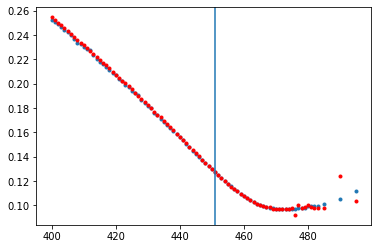

In [24]:
### Plot volatility data ###
x_min = 400
x_max = 495
plot_data = vol_data[(vol_data["Strike"] >= x_min) & (vol_data["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["CallImpliedVol"], '.')
plt.plot(plot_data["Strike"], plot_data["PutImpliedVol"], 'r.')
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()

In [45]:
### Save to CSV file ###

#Point-out at-the-money strike
vol_data["At-the-money"] = (vol_data["Strike"] == atm_strike)

#Save data to CSV
now = datetime.now()
path = r"vols"
path = os.path.join(path, str(ticker))
series_path = r"series_" + str(expiration_date.year) + r"-" + str(expiration_date.month) + r"-" + str(expiration_date.day)
path = os.path.join(path, series_path)
Path(path).mkdir(parents=True, exist_ok=True)
file_name = str(ticker) + "_series_" + str(expiration_date.month) \
            + r"-" + str(expiration_date.day) + r"_" + str(now.year) + r"-" \
            + str(now.month) + r"-" + str(now.day) +  r".csv"
vol_data.to_csv(os.path.join(path, file_name), index=False)

In [43]:

print(vol_data)

     Strike  CallImpliedVol  PutImpliedVol  At-the-money
0     245.0        0.759067       0.621884         False
1     250.0        0.710076       0.611585         False
2     255.0        0.703892       0.592389         False
3     260.0        0.688339       0.582201         False
4     265.0        0.671362       0.571247         False
5     270.0        0.642335       0.558509         False
6     275.0        0.648191       0.546008         False
7     280.0        0.610208       0.533736         False
8     285.0        0.574811       0.519981         False
9     290.0        0.567322       0.506017         False
10    295.0        0.557087       0.496468         False
11    300.0        0.556129       0.485725         False
12    303.0        0.523829       0.477922         False
13    305.0        0.518226       0.473771         False
14    310.0        0.504516       0.462015         False
15    312.0        0.498366       0.457964         False
16    313.0        0.496067    